In [2]:
%matplotlib inline

import numpy as np
import pandas as pd


import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("../data/hr_neighbors.csv")

print "total number of lines =", len(df)

df_clean = df[(df.rssi<0) & (df.distance>0)]

lines_removed = len(df) - len(df_clean)
df_clean.loc[:, "date"] = pd.to_datetime(df_clean.time, unit='s')

print "number of lines removed = ", lines_removed, "(", float(lines_removed)*100/len(df), "% )"
#print "Data from ", df_clean.date[0], "to", df_clean.date[len(df_clean.date)-1]

print df_clean.head()

print len(df.groupby("mac"))

total number of lines = 446542


number of lines removed =  503 ( 0.11264337957 % )
         time                      mac              neighborMac  neighborFlag  \
0  1478099140  00-17-0d-00-00-38-00-63  00-17-0d-00-00-30-5d-39             0   
1  1478099140  00-17-0d-00-00-38-00-63  00-17-0d-00-00-58-eb-5b             0   
2  1478099140  00-17-0d-00-00-38-00-63  00-17-0d-00-00-38-03-dd             0   
3  1478100040  00-17-0d-00-00-38-00-63  00-17-0d-00-00-30-5d-39             0   
4  1478100040  00-17-0d-00-00-38-00-63  00-17-0d-00-00-58-eb-5b             0   

   rssi  numTxPackets  numTxFailures  numRxPackets mote_board ngbr_board  \
0   -64            85              6             7      huron        NaN   
1   -68            67              8             1      huron      huron   
2   -32             0              0            14      huron      huron   
3   -63            91              8             2      huron        NaN   
4   -69            74             10             2      huron      huron   

     

## Link Asymmetry

In [6]:
df_reduced = df_clean#[ 
      #  (df.mote_board == "DC9003A-B")
      #& (df.ngbr_board == "DC9003A-B")
#]

def get_hash(A, B):
    return ''.join(sorted([A, B]))

def check_hash(A, B, hash):
    if ''.join([A, B]) == hash:
        return True
    else:
        return False

df_reduced["hash"] = df_reduced.apply(lambda row: (get_hash(row["mac"], row["neighborMac"])), axis=1)

df_indexed = df_reduced.set_index(df_reduced["date"])

hash_grouped = df_indexed.groupby(["hash"])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
# for each link
for hash, group in hash_grouped:
    AtoB = []
    BtoA = []
    
    # resample and separate A->B and B->A links
    for m, gr in group.groupby(group["mac"]):
        rssi_resampled = gr.rssi.resample('1h').mean()
        
        if check_hash(gr["mac"][0], gr["neighborMac"][0], hash):
            AtoB = rssi_resampled
        else:
            BtoA = rssi_resampled
    
    # compute RSSI difference for each time bin
    rssi_diff = pd.Series(AtoB).subtract(pd.Series(BtoA)).dropna()
    
    # only select link with important traffic
    if len(rssi_diff) > 1000: 
        diff_list.append([str(gr["mac"][0]), str(gr["neighborMac"][0]), len(rssi_diff), abs(rssi_diff.mean()), rssi_diff.std()])
       

print "Total number of nodes:", len(df_indexed.groupby(["mac"]))
print "Total number of active links:", len(diff_list)
print "Total number of HR_NEIGHBORS:", df_clean.count()[1]
print "Active links between ", df_clean.date[0], "and", df_clean.date[len(df_clean.date)-1]

Total number of nodes: 19
Total number of active links: 16
Total number of HR_NEIGHBORS: 446039
Active links between  2016-11-02 15:05:40 and 2017-02-13 21:01:24


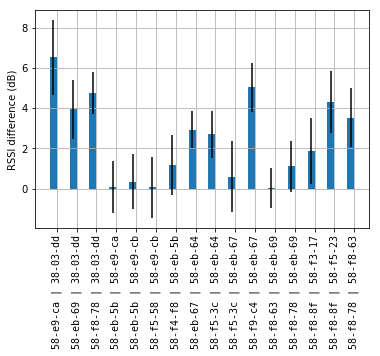

In [21]:
df_final = pd.DataFrame(diff_list, columns=["mac_1", "mac_2", "count", "mean", "std"])
df_final.set_index(["mac_1","mac_2"], inplace=True)

ind = np.arange(len(df_final.index))
bar_width = 0.35

plt.bar(ind, df_final["mean"], bar_width,
        yerr=df_final["std"],
        label="",
        #color=df_final["count"]#, cmap = plt.matplotlib.cm.jet
        )
plt.xticks(ind + bar_width / 2, [str(i[0])[-8:]+ " | " +str(i[1])[-8:] for i in df_final.index],
           rotation=90, fontname="monospace")

#plt.colorbar()

plt.ylabel('RSSI difference (dB)')
plt.legend()

plt.grid(True)

plt.savefig("../figures/asymmetry.eps", format='eps')
plt.show()